# DataCollection
This notebook shows how get data from wiseair servers and integrating it with wheater informations coming from ARPA sensors

The final dataset will be indexed by date and time of the measurement done by each sensor. Each row reports information about
* sensor id (pot_id)
* pm1 levels
* pm2p5 levels
* pm4 levels
* pm10 levels
* humidity
* temperature
* wind speed  (from ARPA)
* rain levels (from ARPA)

Data need to be hourly aggregated to have equally spaced samples in time before further processing, morover the need for hourly aggregation comes from the fact that ARPA data are given in intervals of one hour, thus data crossing cannot be done if wiseair sensors data and ARPA informations are not aligned.
Using daily average is not recommended because interesting patterns may be lost.

In [1]:
import sys
sys.path.insert(0, '../src/')

from DataCollector import DataCollector
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# graphics settings
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcdefaults()
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

In [2]:
# COLLECT DATA, THIS REQUIRES TIME... WAIT UNTIL FINISH BEFORE RUNNING NEXT CELLS

dataCollector = DataCollector()

# write a fresh CSV file containing data for the selected period
# avoid to call this function if you already have a dataset, call updateData() instead
BEGIN_DATE = "2020-06-01"
END_DATE   = "2020-10-25"
dataCollector.getData(BEGIN_DATE, END_DATE, "../data/rawdata.csv")

# automatically update dataset with data up to yesterday
# dataCollector.updateData("data.csv")

fetching data from Wiseair server
progress [################################################################################] 100.0%
got not null data from 68 sensors                                                                                                    
data stored in ../data/rawdata.csv


In [3]:
data = pd.read_csv("../data/rawdata.csv")
data["created_at"] = pd.to_datetime(data["created_at"])
data.set_index("created_at", inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 566745 entries, 2020-09-04 22:23:31 to 2020-10-21 16:45:00
Data columns (total 31 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       566745 non-null  int64  
 1   id                               566745 non-null  int64  
 2   location_id                      566745 non-null  int64  
 3   pot_id                           566745 non-null  int64  
 4   pm2p5                            566745 non-null  int64  
 5   pm10                             566745 non-null  float64
 6   pm1SPS                           566745 non-null  float64
 7   pm2p5SPS                         566745 non-null  int64  
 8   pm4SPS                           566745 non-null  float64
 9   pm10SPS                          566745 non-null  float64
 10  millisSpentMeasuring             566743 non-null  float64
 11  millisSpentConnecting          

In [4]:
# keep only interesting features
interesting = ["pm1SPS", "pm2p5SPS", "pm4SPS", "pm10SPS", "temperature_sht", "humidity_sht", 
               "pot_id", "lat", "lon"]

for feature in list(data.columns.values):
    if feature not in interesting:
        data.drop(feature, axis = 1, inplace = True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 566745 entries, 2020-09-04 22:23:31 to 2020-10-21 16:45:00
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   pot_id           566745 non-null  int64  
 1   pm1SPS           566745 non-null  float64
 2   pm2p5SPS         566745 non-null  int64  
 3   pm4SPS           566745 non-null  float64
 4   pm10SPS          566745 non-null  float64
 5   temperature_sht  566745 non-null  float64
 6   humidity_sht     566745 non-null  float64
 7   lat              566745 non-null  float64
 8   lon              566745 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 43.2 MB


In [5]:
data.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon
created_at,,,,,,,,,
2020-09-04 22:23:31,1157,9.39,10,9.93,9.93,-9.05,20.52,41.826132,12.395317
2020-09-04 22:25:28,1157,12.54,13,13.26,13.26,-7.86,17.70,41.826132,12.395317
2020-09-04 22:30:15,1157,13.30,14,14.06,14.06,-8.53,29.28,41.826132,12.395317
2020-09-04 22:35:14,1157,12.75,13,13.49,13.49,-8.60,26.16,41.826132,12.395317
2020-09-04 22:40:14,1157,13.28,14,14.04,14.04,-8.67,25.66,41.826132,12.395317


## Weather data integration

wheater data are available with hourly frequency. Need to average available data hourly before integrating further informations from ARPA sensors. Data from ARPA sensors are joined to Wiseair data on the base of the datetime index. Be carefull to use ARPA data up to dated with respect to data collected from Wiseair (otherwise athmospheric informations as wind speed and rain levels will be NaN for days for which no data are supplied)

In [9]:
# group data on base of sensors id
groupedData = data.groupby('pot_id', as_index=False)

averagedData = pd.DataFrame()
potID = set(data['pot_id'])

# average data by sensor id
for y in potID:
    tmp = groupedData.get_group(y).resample('H').mean()
    tmp['pot_id'] = tmp['pot_id'].fillna(y)
    tmp['lat'] = tmp['lat'].fillna(method = "ffill")
    tmp['lon'] = tmp['lon'].fillna(method = "ffill")
    averagedData = pd.concat([averagedData, tmp])

# recast pot_id to integer
averagedData['pot_id'] = averagedData['pot_id'].astype(int)

averagedData.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon
created_at,,,,,,,,,
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.715000,32.99125,45.458286,9.16756
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.633333,34.51250,45.458286,9.16756
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.972500,31.95875,45.458286,9.16756
2020-06-24 20:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756
2020-06-24 21:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756


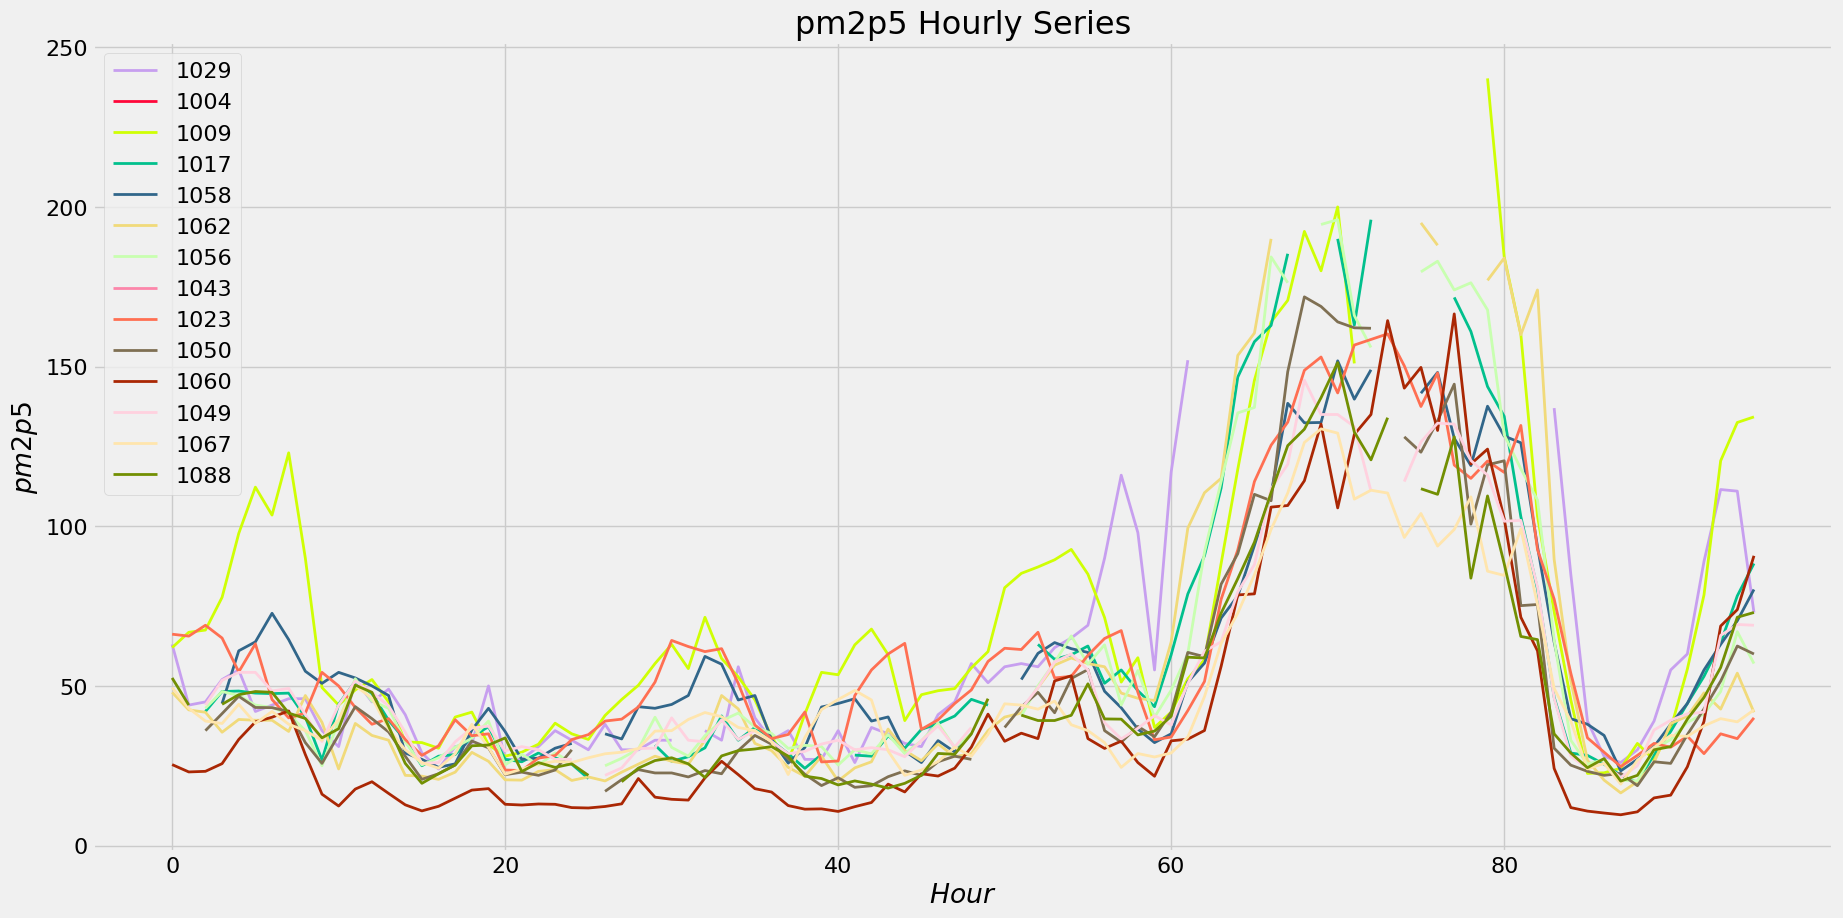

In [10]:
# just a plot to show some data... only the last 4 days are showed

endDate = datetime.strptime(END_DATE, "%Y-%m-%d")
startDate = endDate - timedelta(days = 4)

sensorsToPlot = [1029, 1004, 1009, 1017, 1058, 1062, 1056, 1043, 1023, 1050, 1060, 1049, 1067, 1088]
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(sensorsToPlot), replace=False)

plt.figure(figsize=(8,6))
for j,i in enumerate(sensorsToPlot):
    tmp = averagedData.loc[averagedData['pot_id'] == i]
    tmp = tmp[startDate : endDate]
    
    tmp['hour'] = [d.strftime('%H') for d in tmp.index]
    tmp['colid'] = range(len(tmp['hour']))
    plt.plot('colid', 'pm2p5SPS', data=tmp, color=mycolors[j], label=i)
        
plt.gcf().set_size_inches(20, 10)
plt.gca().set(ylabel='$pm2p5$', xlabel='$Hour$')
plt.title("pm2p5 Hourly Series")
plt.legend()
plt.show()

In [12]:
# weather data integration (data from 01-05-2020 to 25-10-2020)

# importing data from external files...
windSpeed = pd.read_csv('../data/datiArpaVento-01052020-25102020.csv', 
                        names=["ID", "Date", "windSpeed"], header=0)
windSpeed.drop("ID", axis = 1, inplace = True)
windSpeed["Date"] = pd.to_datetime(windSpeed["Date"])
windSpeed.set_index("Date", inplace=True)

rainLevel = pd.read_csv('../data/datiArpaPrecipitazioni-01052020-25102020.csv', 
                        names=["ID", "Date", "rain"], header=0)
rainLevel.drop("ID", axis = 1, inplace = True)
rainLevel["Date"] = pd.to_datetime(rainLevel["Date"])
rainLevel.set_index("Date", inplace=True)

In [13]:
# dataset merge
finalData = pd.concat([averagedData, windSpeed], join='inner', axis=1)
finalData = pd.concat([finalData, rainLevel], join='inner', axis=1)

finalData.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,lat,lon,windSpeed,rain
2020-06-24 17:00:00,1024,7.02875,7.625000,7.502500,7.508750,35.715000,32.99125,45.458286,9.16756,2.0,0.0
2020-06-24 18:00:00,1024,5.52750,6.083333,6.405833,6.456667,35.633333,34.51250,45.458286,9.16756,1.8,0.0
2020-06-24 19:00:00,1024,5.91750,6.625000,6.907500,6.965000,34.972500,31.95875,45.458286,9.16756,1.7,0.0
2020-06-24 20:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756,1.4,0.0
2020-06-24 21:00:00,1024,NaN,NaN,NaN,NaN,NaN,NaN,45.458286,9.16756,2.0,0.0


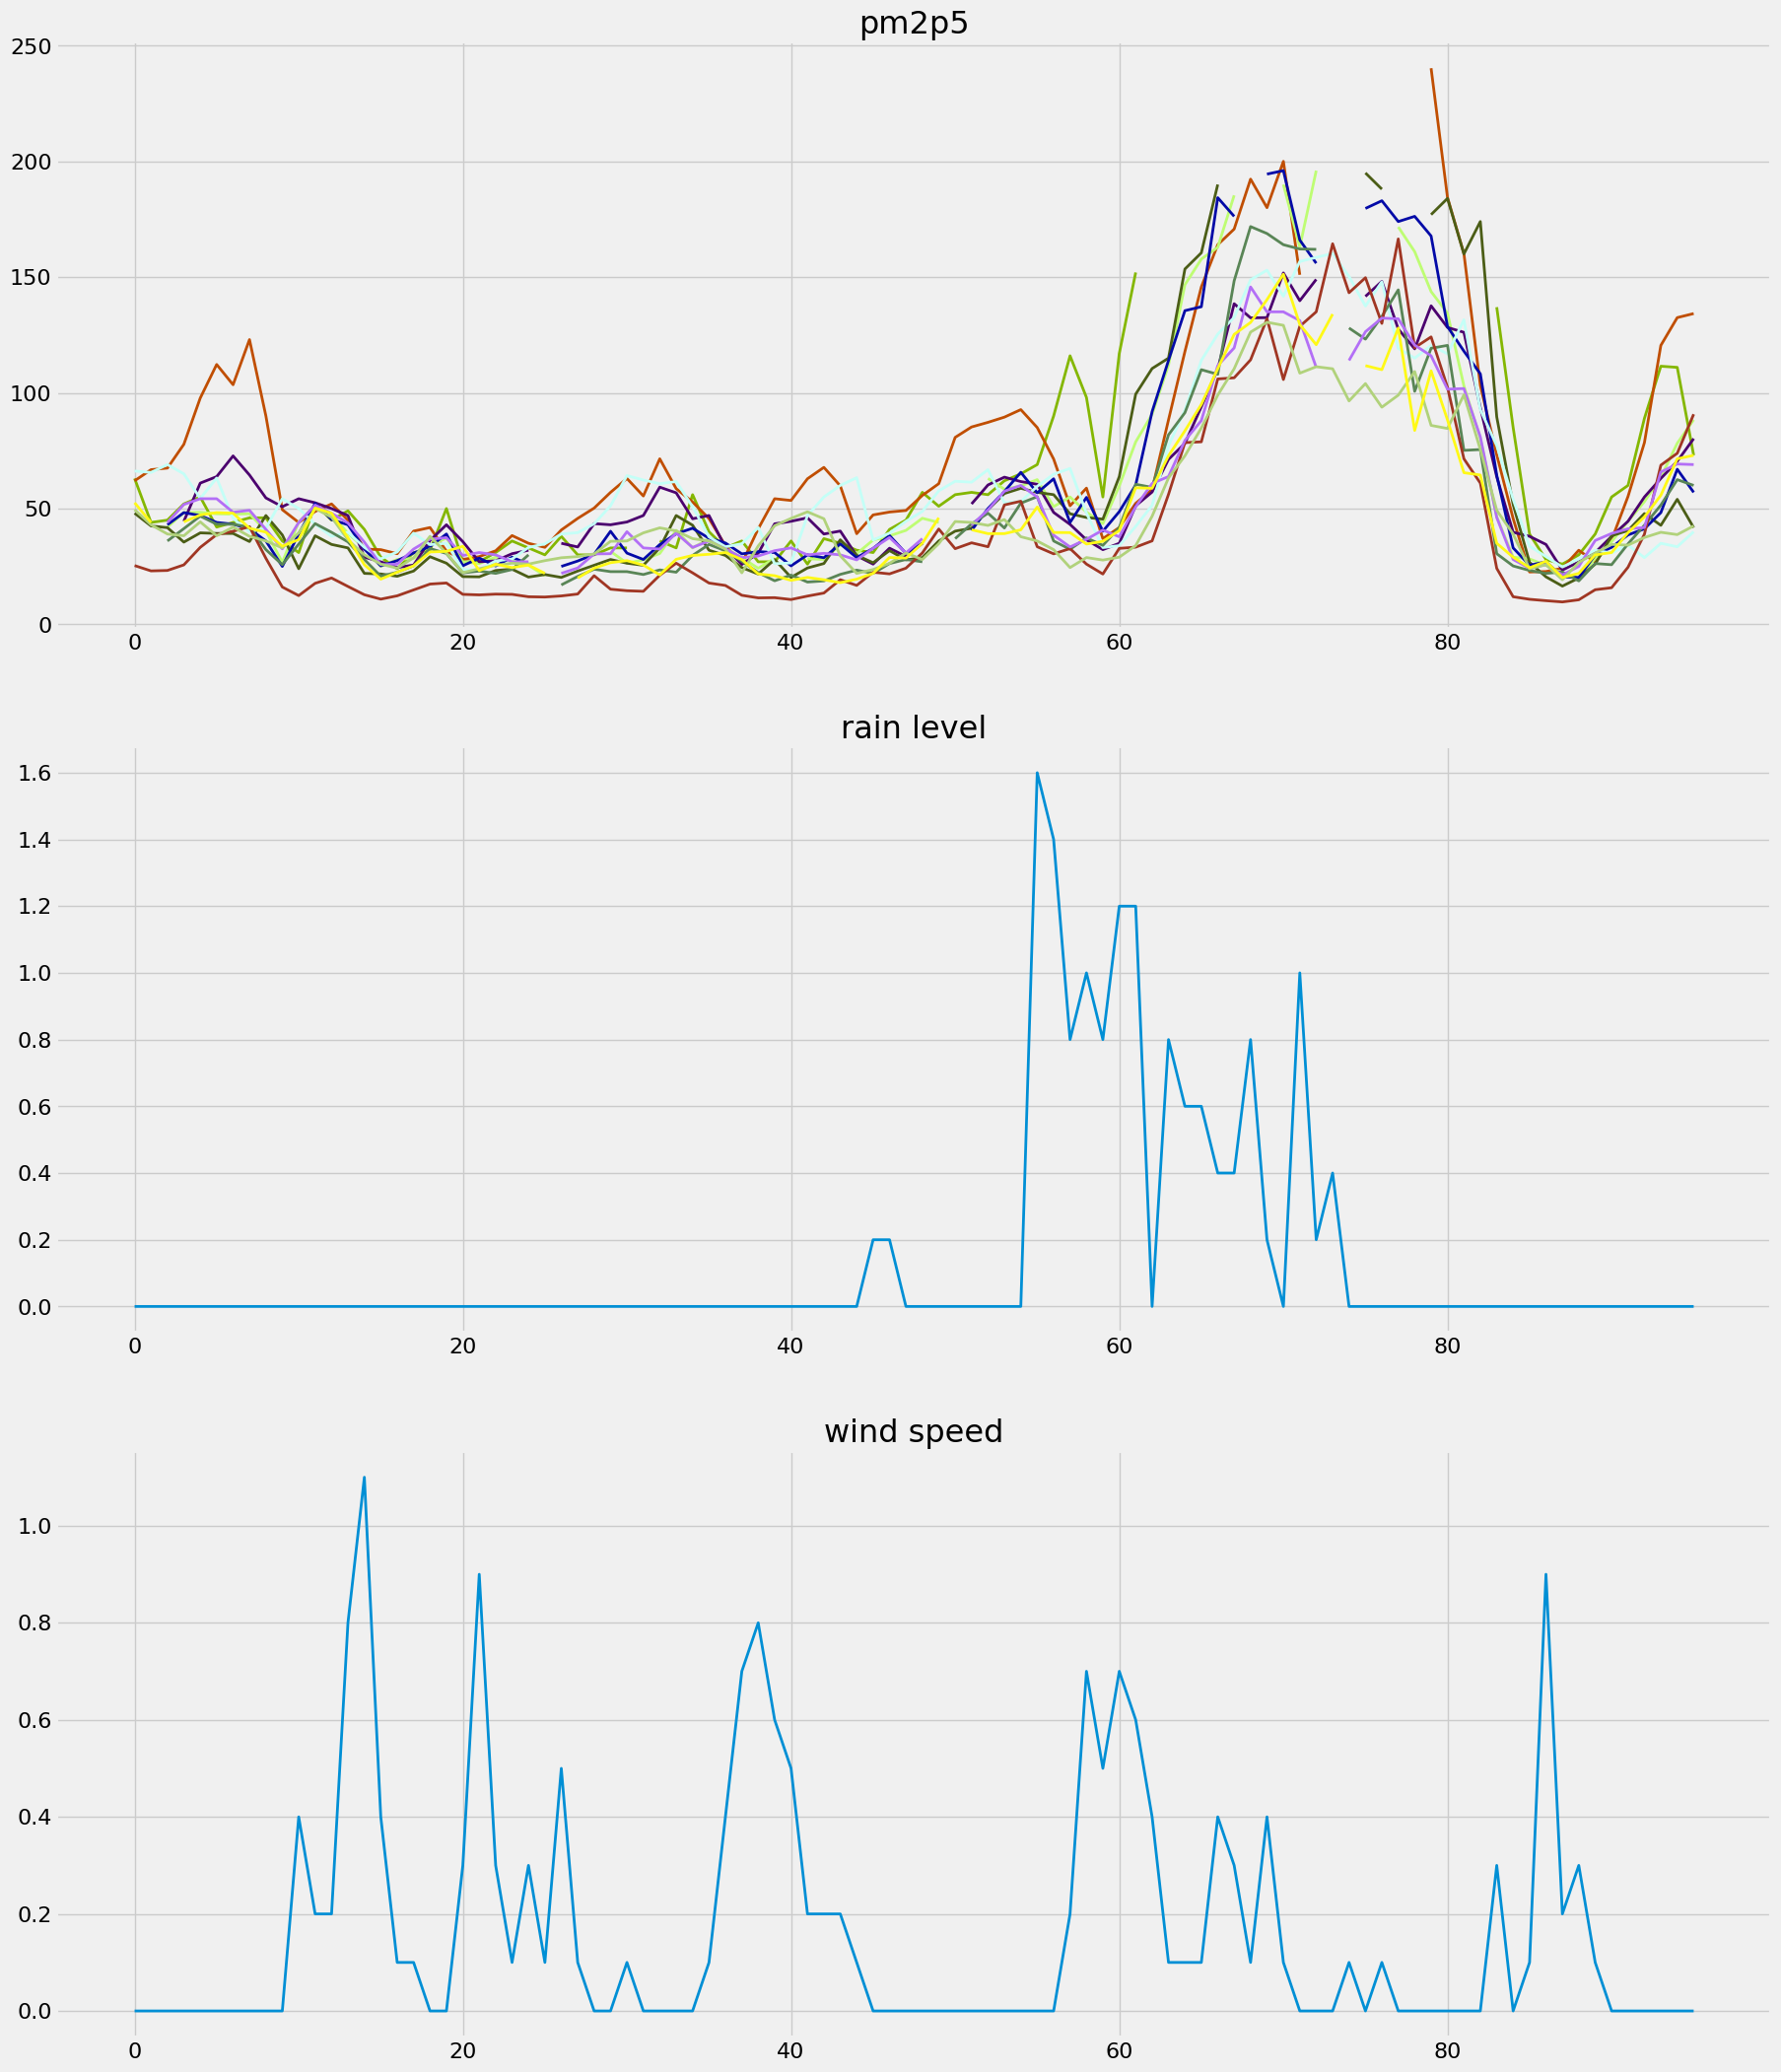

In [14]:
# final plot to show some covariates as function of time. Only the last 4 days are showed

sensorsToPlot = [1029, 1004, 1009, 1017, 1058, 1062, 1056, 1043, 1023, 1050, 1060, 1049, 1067, 1088]
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(sensorsToPlot), replace=False)

fig, axs = plt.subplots(3)
for j,i in enumerate(sensorsToPlot):
    tmp = finalData.loc[finalData['pot_id'] == i]
    tmp = tmp[startDate : endDate]
    
    tmp['hour'] = [d.strftime('%H') for d in tmp.index]
    tmp['colid'] = range(len(tmp['hour']))
    axs[0].plot('colid', 'pm2p5SPS', data=tmp, color=mycolors[j], label=i)

axs[1].plot('colid', 'rain', data=tmp)
axs[2].plot('colid', 'windSpeed', data=tmp)

axs[0].set_title("pm2p5")
axs[1].set_title("rain level")
axs[2].set_title("wind speed")

plt.gcf().set_size_inches(20, 25)
plt.show()

The final dataset can now be esported in csv and used for next studies

In [15]:
finalData.index.name = "created_at"
finalData.to_csv("../data/tsData.csv")